#Target Control
This is an unofficial implementation of Self-guidance (appearance part) and layout guidance.

This work aims to conveniently reuse satisfying elements during image generations, without any additional training. The code enables easy copying of target appearances between generated images, with user-defined positions.


In [1]:
!git clone https://github.com/lindapu-1/my_layout_guidance.git

Cloning into 'my_layout_guidance'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 76 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (76/76), 194.92 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
!cd my_layout_guidance
!pip install torch transformers diffusers==0.7.2 numpy pillow tqdm accelerate #omegaconf==2.2.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.9/304.9 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


In [1]:
cd my_layout_guidance

/content/my_layout_guidance


In [ ]:
import torch
import math
import random
#from omegaconf import OmegaConf
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms

from diffusers import AutoencoderKL, LMSDiscreteScheduler, PNDMScheduler
from my_model import unet_2d_condition
import json
from PIL import Image, ImageDraw
from utils import compute_ca_loss, Pharse2idx, draw_box, setup_logger
#import hydra
import os
from tqdm import tqdm
from IPython.display import display


with open('./conf/unet/config.json') as f:
        unet_config = json.load(f)
model_path='runwayml/stable-diffusion-v1-5' ####
#model_path="stabilityai/stable-diffusion-2"

unet = unet_2d_condition.UNet2DConditionModel(**unet_config).from_pretrained(model_path, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet.to(device)
text_encoder.to(device)
vae.to(device)

In [3]:
def binarize(attention):#now attn has size(1, s1, 1)
    def maxmin_norm(x):
        norm = (x - torch.min(x, 1, keepdim=True)[0])/ (torch.max(x, 1, keepdim=True)[0] - torch.min(x, 1, keepdim=True)[0])
        return norm

    s = 10.
    attn_new = maxmin_norm((s * (maxmin_norm(attention) - 0.5)).sigmoid())
    return attn_new

def property_aa(attention_k, activation, device):#activation has shape b, c, h, w
  #centroid
  shape=int(math.sqrt(attention_k.shape[1]))

  ls = torch.linspace(0, 1, steps=shape).to(device) #activation.shape[-1]=innerD
  col = ls.repeat(shape, 1)
  row = col.t()#transpose

  col = torch.stack([col], dim=0).view(1, -1)
  row = torch.stack([row], dim=0).view(1, -1)

  attn_col = (attention_k * col.unsqueeze(-1)).sum(1) / attention_k.sum(1)
  attn_row = (attention_k * row.unsqueeze(-1)).sum(1) / attention_k.sum(1)

  #shape
  attn_shape = binarize(attention_k)#now attention_k has size (b, s1, 1)

  ### size
  attn_size = attn_shape.sum(1) / shape ** 2

  ### appearance
  actv = activation.view(activation.shape[0], activation.shape[1], -1)#batch, channels, H*W
  appr = (actv.unsqueeze(2) * attn_shape.unsqueeze(1).transpose(2,3)).sum(-1) / attn_shape.sum(1).unsqueeze(1) #appr has shape b, c, 1
  #actv.unsqueeze(2)-> b, c, 1, HW
  # attn_shape.unsqueeze(1)-> b, 1, H*W, 1
  # .transpose(2,3)-> b, 1, 1, HW
  #*-> b, c, 1  HW
  #.sum->b, c, 1

  return attn_col, attn_row, attn_shape, attn_size, appr

#stable diffusion w/o any guidance

In [6]:
def encode_text(prompt):

  uncond_input = tokenizer(
          "", padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
      )

  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
  input_ids = tokenizer(
          prompt,
          padding="max_length",
          truncation=True,
          max_length=tokenizer.model_max_length,
          return_tensors="pt",
      )

  cond_embeddings = text_encoder(input_ids.input_ids.to(device))[0]
  return cond_embeddings, torch.cat([uncond_embeddings, cond_embeddings])

def target_index(prompt, target):
  for index, i in enumerate(prompt.split()):
    if target==i: return torch.tensor([index+1])

def stablediffusion(text_embeddings, seed=None):

  if seed is None: seed = random.randrange(2**32 - 1)

  generator = torch.manual_seed(seed)
  latents = torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)

  noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler.set_timesteps(51)

  latents = latents * noise_scheduler.init_noise_sigma

  for index, t in enumerate(tqdm(noise_scheduler.timesteps)):

    with torch.no_grad():
      latent_model_input = torch.cat([latents] * 2)
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down,_,_,_ = \
          unet(latent_model_input, t, encoder_hidden_states=text_embeddings)

      noise_pred = noise_pred.sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

      latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
      torch.cuda.empty_cache()
  return latents


def decode_img(latents):
  with torch.no_grad():
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(*pil_images)

100%|██████████| 51/51 [00:05<00:00,  8.62it/s]


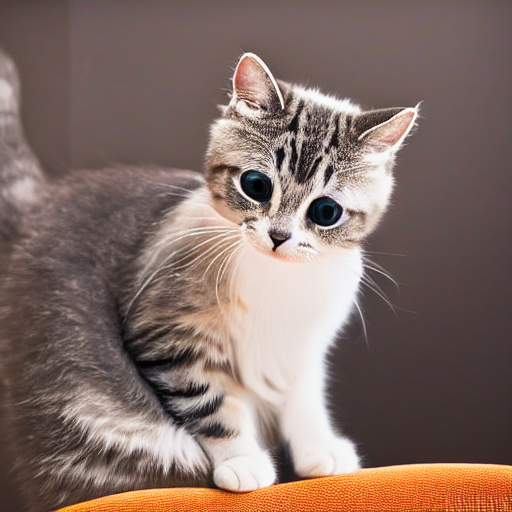

In [63]:
decode_img(stablediffusion(encode_text("a phote of a cute cat sitting")[1], seed=1))

#Appearance copy
When you find a satisfying item in the generated images, you may want to retain it in a new image. In this case, the new image is generated with guidance from original image.

What you need to provide:

  **ori_seed, ori_prompt** (so that you can recreate original imgae)

  **new_seed**(opt), **new_prompt**(it can be the same as ori_prompt),
  
  **target that you want to copy** (it'd better appear in both prompts)




In [13]:
#source: prompt, seed-->recreate
#new: prompt, seed(optional), target

def appr_control(ori_seed,
                 ori_prompt,
                 new_prompt,
                 target,
                 new_seed=None):

  #get text embedding
  ori_text_embeddings = encode_text(ori_prompt)[1]

  new_text_embeddings = encode_text(new_prompt)[1]
  new_cond_embeddings = encode_text(new_prompt)[0]

  #get position of target in each prompt
  position_ori=target_index(ori_prompt,target)
  position_new=target_index(new_prompt,target)

  #seperate scheduler should be used for ori and new img
  noise_scheduler_org = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler_org.set_timesteps(51)

  generator = torch.manual_seed(ori_seed)
  latents_org = torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)
  latents_org = latents_org * noise_scheduler_org.init_noise_sigma

  noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  noise_scheduler.set_timesteps(51)

  if new_seed is None: new_seed = random.randrange(2**32 - 1)
  generator = torch.manual_seed(new_seed)
  latents=torch.randn(
          (1, 4, 64, 64),
          generator=generator,
      ).to(device)
  latents=latents* noise_scheduler.init_noise_sigma

  #update latent for new img


  ####################################################################start iteration
  for index, t in enumerate(tqdm(noise_scheduler.timesteps)):

    ###recreate org image
    with torch.no_grad():
      latent_model_input_org = torch.cat([latents_org] * 2)
      latent_model_input_org = noise_scheduler_org.scale_model_input(latent_model_input_org, t)
      noise_pred_org, attn_map_integrated_up_org, attn_map_integrated_mid_org, attn_map_integrated_down_org, act_up_org, act_mid_org, act_down_org = \
          unet(latent_model_input_org, t, encoder_hidden_states=ori_text_embeddings)

      noise_pred_org = noise_pred_org.sample

      noise_pred_uncond_org, noise_pred_text_org = noise_pred_org.chunk(2)
      noise_pred_org = noise_pred_uncond_org + 7.5 * (noise_pred_text_org - noise_pred_uncond_org)

      latents_org = noise_scheduler_org.step(noise_pred_org, t, latents_org).prev_sample

    torch.cuda.empty_cache()
    ###end recreate ori image
    loss=torch.tensor(10000)
    iter=0
    #####upadate latent for new img
    while loss.item()>0.1 and ((index<11 and iter<5) or (index%5==0 and index<25 and iter<5)): #you can change the threshold
      list_score=[]

      #temperary forward of new img
      latents = latents.requires_grad_(True)

      latent_model_input = latents#tmp
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input,t)

      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down, act_up, act_mid, act_down= \
        unet(latent_model_input, t, encoder_hidden_states=new_cond_embeddings)


      ###obtain list of attention layers
      list_aa_org=[]
      list_act_org=[]

      for block1, block2 in zip(attn_map_integrated_down_org, act_down_org):
        for trans1, trans2 in zip(block1, block2):
          list_aa_org.append(trans1.chunk(2)[1])
          list_act_org.append(trans2.chunk(2)[1])

      for trans1, trans2 in zip(attn_map_integrated_mid_org, act_mid_org):
        list_aa_org.append(trans1.chunk(2)[1])
        list_act_org.append(trans2.chunk(2)[1])

      for block1, block2 in zip(attn_map_integrated_up_org, act_up_org):
        for trans1, trans2 in zip(block1, block2):
          list_aa_org.append(trans1.chunk(2)[1])
          list_act_org.append(trans2.chunk(2)[1])

      #obtain list_aa
      list_aa=[]
      list_act=[]

      for block1, block2 in zip(attn_map_integrated_down, act_down):
        for trans1, trans2 in zip(block1, block2):
          list_aa.append(trans1)
          list_act.append(trans2)

      for trans1, trans2 in zip(attn_map_integrated_mid, act_mid):
        list_aa.append(trans1)
        list_act.append(trans2)

      for block1, block2 in zip(attn_map_integrated_up, act_up):
        for trans1, trans2 in zip(block1, block2):
          list_aa.append(trans1)
          list_act.append(trans2)

      ###now list_aa contain attn-map elements


      w1=10. #for weight of appr (if there are other prop)
      v=10. #for adjusting grad size


      ###extract object's attn slice of each map
      for idx, (aa, act) in enumerate(zip(list_aa, list_act)):
        aa_org=list_aa_org[idx]
        act_org=list_act_org[idx]

        attention_k1 = aa[:,:,position_new].mean(-1, keepdim=True) #sweater

        attention_k1_org=aa_org[:,:,position_ori].mean(-1, keepdim=True)

        #score_centroid = 2.0 * (torch.abs(aa_col -0.9).mean(-1) + torch.abs(aa_row - 0.2).mean(-1)) / 2.
        #score_shape=10*torch.abs(aa_shape-aa_shape_org).mean(-2).mean(-1)

        if idx not in [2,4,5,6,7,8]:
        #if idx not in [50]:
          aa_col1, aa_row1, aa_shape1, aa_size1, aa_appr1 =property_aa(attention_k1, act, device=device) #extract prop for k1

          aa_col_org, aa_row_org, aa_shape_org, aa_size_org, aa_appr_org =property_aa(attention_k1_org, act_org, device=device)

          score_appr= w1 * torch.abs(aa_appr1 - aa_appr_org).mean(-2).mean(-1)
          list_score.append(score_appr)#score in all maps
      ###end extraction object's feature


      #update latent by gradient decent
      loss = torch.mean(torch.stack(list_score, dim=0), dim=0)[0]
      grad_cond = torch.autograd.grad(loss.requires_grad_(True), [latents])[0]
      #grad_cond=0


      latents = latents -v*grad_cond * noise_scheduler.sigmas[index] #update new_latent according to the guidance
      torch.cuda.empty_cache()
      iter+=1

      print(f'iteration {iter}, loss={loss.item()}')
  ######end update latent for new img

    with torch.no_grad(): #for new img
      latent_model_input = torch.cat([latents] * 2)
      latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
      noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down, _, _, _ = \
          unet(latent_model_input, t, encoder_hidden_states=new_text_embeddings)

      noise_pred = noise_pred.sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

      latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
      torch.cuda.empty_cache()
  return latents


In [ ]:
ori_seed=1
ori_prompt='a photo of cute cat siting'
new_prompt='a photo of cute cat standing on the tree'
target='cat'
new_seed=10

decode_img(appr_control(ori_seed=ori_seed, ori_prompt=ori_prompt,
                 new_prompt=new_prompt,
                 target=target,
                 new_seed=new_seed))

#More examples

100%|██████████| 51/51 [00:05<00:00,  8.61it/s]


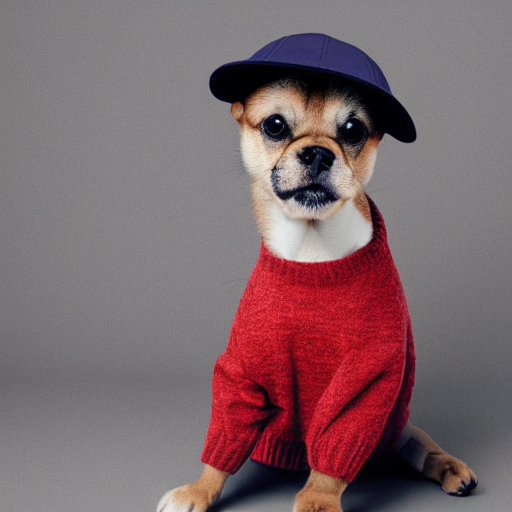

In [15]:
#ori image
prompt="a photo of a cute dog wearing a sweater and a baseball cap"
decode_img(stablediffusion(encode_text(prompt)[1], seed=15))

  0%|          | 0/51 [00:00<?, ?it/s]

iteration 1, loss=2.231111526489258
iteration 2, loss=2.3733937740325928
iteration 3, loss=2.1676669120788574
iteration 4, loss=2.14880633354187


  2%|▏         | 1/51 [00:01<01:04,  1.30s/it]

iteration 5, loss=2.184903860092163
iteration 1, loss=2.1742441654205322
iteration 2, loss=2.1302740573883057
iteration 3, loss=2.2681751251220703
iteration 4, loss=2.911409378051758


  4%|▍         | 2/51 [00:02<01:02,  1.27s/it]

iteration 5, loss=2.6909725666046143
iteration 1, loss=3.0258233547210693
iteration 2, loss=2.958566904067993
iteration 3, loss=2.8829779624938965
iteration 4, loss=2.8437135219573975
iteration 5, loss=2.7987725734710693


  6%|▌         | 3/51 [00:03<01:00,  1.26s/it]

iteration 1, loss=3.1117255687713623
iteration 2, loss=3.0328121185302734
iteration 3, loss=2.9039664268493652
iteration 4, loss=2.9774703979492188


  8%|▊         | 4/51 [00:05<00:58,  1.25s/it]

iteration 5, loss=2.41434907913208
iteration 1, loss=2.885561466217041
iteration 2, loss=2.8906803131103516
iteration 3, loss=2.7458972930908203
iteration 4, loss=2.6890201568603516
iteration 5, loss=2.6497466564178467


 10%|▉         | 5/51 [00:06<00:57,  1.25s/it]

iteration 1, loss=3.2071423530578613
iteration 2, loss=4.1391825675964355
iteration 3, loss=3.7623984813690186
iteration 4, loss=3.497807264328003


 12%|█▏        | 6/51 [00:07<00:55,  1.24s/it]

iteration 5, loss=3.0408222675323486
iteration 1, loss=4.441747188568115
iteration 2, loss=4.677084445953369
iteration 3, loss=4.174092769622803
iteration 4, loss=3.9484360218048096


 14%|█▎        | 7/51 [00:08<00:54,  1.24s/it]

iteration 5, loss=3.8627052307128906
iteration 1, loss=4.013253688812256
iteration 2, loss=3.816045045852661
iteration 3, loss=3.7660720348358154
iteration 4, loss=3.725675344467163


 16%|█▌        | 8/51 [00:09<00:53,  1.24s/it]

iteration 5, loss=3.6882824897766113
iteration 1, loss=4.2923994064331055
iteration 2, loss=3.801826238632202
iteration 3, loss=3.6776885986328125
iteration 4, loss=3.6190879344940186


 18%|█▊        | 9/51 [00:11<00:52,  1.24s/it]

iteration 5, loss=3.576354742050171
iteration 1, loss=3.7748138904571533
iteration 2, loss=3.6312789916992188
iteration 3, loss=3.5768043994903564
iteration 4, loss=3.5516934394836426


 20%|█▉        | 10/51 [00:12<00:50,  1.24s/it]

iteration 5, loss=3.528715133666992
iteration 1, loss=3.726973295211792
iteration 2, loss=3.5232319831848145
iteration 3, loss=3.4848287105560303
iteration 4, loss=3.45202374458313


 22%|██▏       | 11/51 [00:13<00:49,  1.24s/it]

iteration 5, loss=3.4256553649902344


 29%|██▉       | 15/51 [00:14<00:16,  2.14it/s]

iteration 1, loss=4.153843879699707
iteration 2, loss=4.0337419509887695
iteration 3, loss=3.975332736968994
iteration 4, loss=3.921044111251831


 31%|███▏      | 16/51 [00:15<00:24,  1.43it/s]

iteration 5, loss=3.9030404090881348


 39%|███▉      | 20/51 [00:16<00:10,  2.94it/s]

iteration 1, loss=4.856398105621338
iteration 2, loss=5.090864658355713
iteration 3, loss=5.543508529663086
iteration 4, loss=5.2166595458984375


 41%|████      | 21/51 [00:17<00:18,  1.65it/s]

iteration 5, loss=4.671555042266846


100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


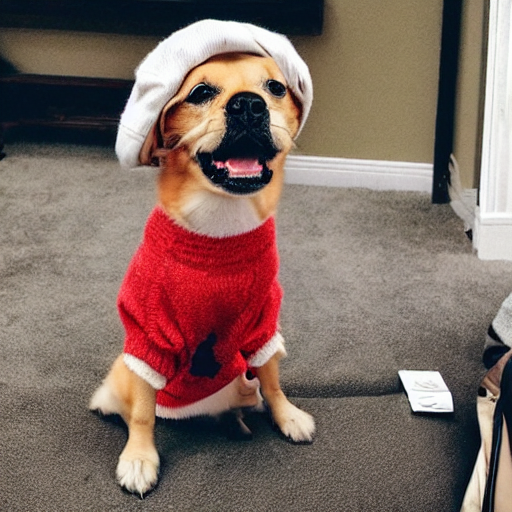

In [16]:
#copy the sweater in new img
ori_seed=15
ori_prompt="a photo of a cute dog wearing a sweater and a baseball cap"
new_prompt=ori_prompt
target='sweater'
new_seed=None

decode_img(appr_control(ori_seed=ori_seed, ori_prompt=ori_prompt,
                 new_prompt=new_prompt,
                 target=target,
                 new_seed=new_seed))